In [2]:
# imports 
import os 
import tensorflow as tf 
import cv2 
import numpy
from matplotlib import pyplot as plt

# making GPU be used, and setting memory limits
memoryLimit = 1024 * 7 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=memoryLimit)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


## basic functions

In [38]:
# setting up the functions to convert from chars to num and vice versa
vocab = [x for x in "ABCDEFGHIJKLMNOPQRSTUVWXYZ'?!123456789 "]
charToNum = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
numToChar = tf.keras.layers.StringLookup(vocabulary=charToNum.get_vocabulary(), oov_token="", invert=True)

# facial detection vars 
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
lastKnownCrop = (0, 0, 256, 250)

# data dir
rootDir = 'A:\Lip Reading\Potential Datasets\BBC LRS2\mvlrs_v1\main'

batchSize = 2

In [39]:
def faceDetection(img):
    # TROUBLESHOOTING
    # print("max size:",img.shape, img.shape[0] - 3 * padding, img.shape[1] - 3 * padding)
    return faceCascade.detectMultiScale(
        img,
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(30, 30),
    )

def cropForMouth(img) -> numpy.ndarray:
    global lastKnownCrop
    rects = faceDetection(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    
    # finding the largest face in a given image 
    largestFace = (0,0,0,0)
    for (x, y, w, l) in rects:
        if (w * l) > largestFace[2] * largestFace[3]:
            largestFace = (x, y,w,l)
        
    if largestFace == (0,0,0,0):
        largestFace =lastKnownCrop
    # cropping for face 
    lastKnownCrop = largestFace
    y1 = lastKnownCrop[1] 
    x1 = lastKnownCrop[0]
    y2 = y1 + lastKnownCrop[3] 
    x2 = x1 + lastKnownCrop[2]
    return img[y1 + int(0.65 * lastKnownCrop[3]): y2, x1 + int(0.05 * lastKnownCrop[2]): int(0.95 * x2)]

In [40]:
def loadData(path): 
    # tf has the paths as bytes so decode that
    path = bytes.decode(path.numpy())
    
    # extract just the file names
    global rootDir
    fileName = path.split('\\')[-1].split('.')[0]
    fileFolder = path.split('\\')[-2]
    # generate the respective paths of the data
    videoPath = os.path.join(rootDir,fileFolder,f'{fileName}.mp4')
    alignmentPath = os.path.join(rootDir,fileFolder,f'{fileName}.txt')
    
    # return the frames and alignments
    frames = loadVideo(videoPath) 
    alignments = loadText(alignmentPath)
    return frames, alignments

def loadVideo(path): 
    cap = cv2.VideoCapture(path)
    global lastKnownCrop
    processedFrames = []
    
    # for each frame 
    for n in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        
        # in case a frame is missing, just continue
        if frame is None or frame.shape[0] == 0: 
            continue
        
        # crop only the mout like we'll do on the RPI 
        frame = cropForMouth(frame)
        frame = cv2.resize(frame, (150, 50))
        
        try: frame = tf.image.rgb_to_grayscale(frame)
        except: continue
    
        processedFrames.append(frame)
    cap.release()

    # generate the normalized frames (deviation from the average) 
    mean = tf.math.reduce_mean(processedFrames, keepdims=True)
    std = tf.math.reduce_std(tf.cast(processedFrames, tf.float32), axis=[0, 1, 2], keepdims=True)
    frames = tf.cast(processedFrames, tf.float32)
    normalizedFrames = (tf.cast(frames, tf.float32) - tf.cast(mean, tf.float32)) / tf.cast(std, tf.float32)

    return normalizedFrames

def loadText(path): 
    # open and parse the file 
    with open(path, 'r') as file: lines = file.readlines()
    file.close()
    
    # return the number equivalent of each of the characters of the word 
    tokens = []
    words = lines[0].split()
    del words[0]
    for word in words: tokens = [*tokens,' ', word]
    
    return charToNum(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]   

def processData(path): 
    return tf.py_function(loadData, [path],  (tf.float32, tf.int64))

In [41]:
def getFrameCount(path) -> int: 
    cap = cv2.VideoCapture(path)
    frameCount = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.release()
    return frameCount
def getCharCount(path) -> int: 
    return len(loadText(path))
#     

In [42]:
rawPath = "A:\\Lip Reading\\Potential Datasets\\BBC LRS2\\mvlrs_v1\\main\\5535415699068794046\\00001.mp4"
tensorPath = tf.convert_to_tensor(rawPath, dtype=tf.string)
path = bytes.decode(tensorPath.numpy())

fileName = path.split('\\')[-1].split('.')[0]
fileFolder = path.split('\\')[-2]

# testing if the loadData, loadVideo, and loadText function all work|
videoPath = os.path.join(rootDir,fileFolder,f'{fileName}.mp4')
alignmentPath = os.path.join(rootDir,fileFolder,f'{fileName}.txt')
loadVideo(videoPath)
loadText(alignmentPath)

frames, text = loadData(tensorPath)

In [43]:
# finding the max number of frames & chars in a certain video 
frameCt = []
charCt = []
# iterating through each file in the root folder
# for subdir, dirs, files in os.walk(rootDir):
#     for file in files:
#         if file.split('.')[1] == "mp4": frameCt.append(getFrameCount(os.path.join(subdir, file)))
#         if file.split('.')[1] == "txt": charCt.append(getCharCount(os.path.join(subdir, file)))
# print("frameCt", max(frameCt))
# print("charCt", max(charCt))
#         print(os.path.join(subdir, file))

In [44]:
maxframeCt = 154
maxCharCt = 99

## reading data

In [45]:
# reading all files within the root directory
data = tf.data.Dataset.list_files('A:\Lip Reading\Potential Datasets\BBC LRS2\mvlrs_v1\main\*\*.mp4')

data = data.shuffle(1500, reshuffle_each_iteration=False) # shuffling data
data = data.map(processData) # "processing" the data to obtain frames and the respective text 

dim1 = frames.shape[1]
dim2 = frames.shape[2]
print("dataset size before padding:", len(data))
print("data shape of example video:", frames.shape)

# combining 8 videos as one "input"
# ensuring all videos are padded to match the longest video, 
# ensuring the length of all the alignments is the size of the longest text characters, as some are lower. 
data = data.padded_batch(batchSize, padded_shapes=([maxframeCt,dim1, dim2,1], [maxCharCt])) 
data = data.prefetch(tf.data.AUTOTUNE)
print("data length after padding:", len(data))

trainThreshold = int(0.04 * len(data))
testThreshold = int(0.99 * len(data))
train = data.take(trainThreshold)
test = data.skip(testThreshold)
print("testing data size:", trainThreshold*batchSize)

dataset size before padding: 48165
data shape of example video: (35, 50, 150, 1)
data length after padding: 24083
testing data size: 1926


154


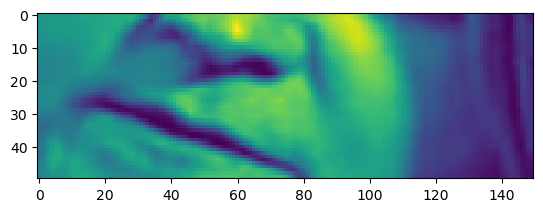

In [46]:
val = data.as_numpy_iterator().next()[0]
plt.imshow(val[0][0])
print(len(val[0]))

## designing the model

In [47]:
# imports for the model architecture 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPooling3D, Activation, Reshape, SpatialDropout3D,BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [48]:
inputShape = data.as_numpy_iterator().next()[0][0].shape
print(inputShape)

(154, 50, 150, 1)


In [49]:
# model to be actually trained
model = Sequential([
Conv3D(128, 3, input_shape=inputShape, padding='same', activation='relu'),
MaxPooling3D((1,3,5)),

Conv3D(256, 3, padding='same', activation='relu'),
MaxPooling3D((1,3,5)),

Conv3D(154, 3, padding='same', activation='relu'),
MaxPooling3D((1,3,5)),

TimeDistributed(Flatten()),

Bidirectional(LSTM(128, return_sequences=True)),
Dropout(.5),

Bidirectional(LSTM(128,  return_sequences=True)),
Dropout(.5),

Dense(charToNum.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax')
])

# model to be actually trained
model3 = Sequential([
Conv3D(32, 3, input_shape=inputShape, padding='same', activation='relu'),
MaxPooling3D((1,2,2)),

Conv3D(64, 3, input_shape=inputShape, padding='same', activation='relu'),
MaxPooling3D((1,2,2)),

Conv3D(154, 3, padding='same', activation='relu'),
MaxPooling3D((1,2,2)),

TimeDistributed(Flatten()),

Bidirectional(LSTM(64, return_sequences=True)),
Dropout(0.5),

Bidirectional(LSTM(64, return_sequences=True)),
Dropout(0.5),

Dense(charToNum.vocabulary_size()+1, activation='softmax')
])

In [50]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 154, 50, 150, 128  3584      
                             )                                   
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 154, 16, 30, 128)  0        
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 154, 16, 30, 256)  884992    
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 154, 5, 6, 256)   0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 154, 5, 6, 154)    1064602   
                                                      

In [51]:
# custom functions 
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
# custom loss function 
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        
        decoded = tf.keras.backend.ctc_decode(yhat, [maxframeCt,maxframeCt], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(numToChar(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(numToChar(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [52]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss=CTCLoss)
checkpointCallback = ModelCheckpoint('newLipModel.weights.h5', monitor='loss',save_weights_only=False) 
scheduleCallback = LearningRateScheduler(scheduler)
exampleCallback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpointCallback, scheduleCallback, exampleCallback])

Epoch 1/100
916/963 [===========================>..] - ETA: 34s - loss: inf